In [24]:
import os
import toml
import wandb
from pycocotools.coco import COCO
import numpy as np
import torch
import torch.nn as nn
import skimage.io as io

import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms.functional as tf
from torch.utils.data import DataLoader

from src.utils import set_seed
from src.dataloader import COCODataset, Transformations, COCODatasetInference
from src.model import DeepLabV3
from src.train_utils import train_model

from src.utils import load_model, plot_batch_sample_inference, infer_img, ErodeDilate, infer_bboxes
from src.losses import jaccard, score_model

# Paths:

In [2]:
DATA_PATH = "/home/glebk/Datasets/dataset_ocr" 
CFG_PATH = "/home/glebk/VSProjects/projects/tmp/src/cfg.toml"
WEIGHTS = "/home/glebk/VSProjects/projects/tmp/weights/DeepLabV3_0.094.pth"


In [ ]:
# Load config:
cfg = toml.load(CFG_PATH)

# Init transformations:
t_test = Transformations(cfg["img_size"], 0, 0, cfg["mask_size"])

In [6]:
# Init train dataset: 
annot_file_train = os.path.join(DATA_PATH, "train_tf" + ".json")
coco_train = COCO(annot_file_train)
dataset_train = COCODataset(coco_train, DATA_PATH, t_test)

# Init test dataset: 
annot_file_test = os.path.join(DATA_PATH, "test" + ".json")
coco_test = COCO(annot_file_test)
dataset_test = COCODataset(coco_test, DATA_PATH, t_test)


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


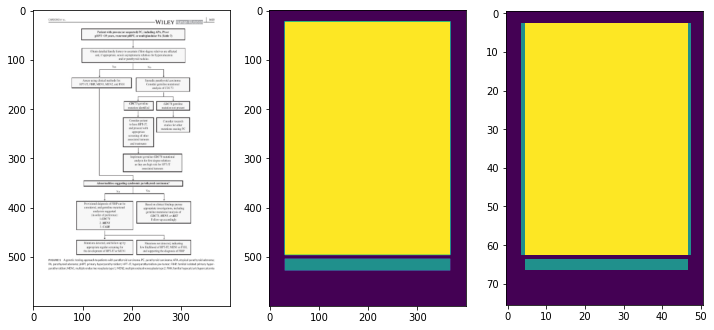

In [8]:
# Plot img and mask and resized mask examples:

idx = np.random.randint(len(dataset_test))
img, mask, resized_mask = dataset_test[idx]

fig, ax = plt.subplots(1, 3, figsize=(12, 12), sharey=False)
ax[0].imshow(tf.to_pil_image(img))
ax[1].imshow(mask[0])
ax[2].imshow(resized_mask[0])

In [9]:
# Init dataloaders:
train_loader = DataLoader(dataset_train, batch_size=cfg["bs_val"], shuffle=True)
val_loader = DataLoader(dataset_test, batch_size=cfg["bs_val"], shuffle=False)

print("Train size: ", len(train_loader))
print("Val size: ", len(val_loader))


857
170


In [10]:
# Init model:

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = DeepLabV3(
    n_classes=cfg["n_classes"],
    n_blocks=cfg["n_blocks"],
    atrous_rates=cfg["atrous_rates"],
    multi_grids=cfg["multi_grids"],
    output_stride=cfg["output_stride"],
).to(device)

model = load_model(WEIGHTS, model, device)

In [12]:
# Test loader iter: 

dl = iter(val_loader)

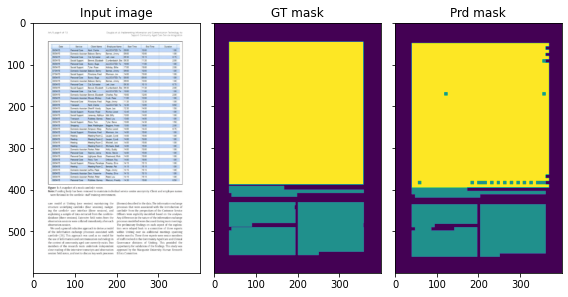

In [14]:
# Inference sample:

batch = img, _, mask = next(dl)
plot_batch_sample_inference(model, batch, device)

In [17]:
# Score IoU for classes:

iou_mean, iou_std = score_model(model, val_loader, device, None)

100%|██████████| 170/170 [00:10<00:00, 16.40it/s]


(array([0.80714654, 0.74804312, 0.86306422]),
 array([0.05893561, 0.18161993, 0.06908823]))

In [ ]:
labels = 3
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 6))

ax.bar(x - width/2, iou_mean, width, label='UNet')
ax.errorbar(x - width/2, iou_mean, yerr=iou_std, fmt='.k')

# ax.set_title(name)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
  
ax.set_ylabel('Scores')
fig.tight_layout()

In [23]:
# Postpocessing with dilation and erosion:

postproc = ErodeDilate(3, 5, 2)
score_model(model, val_loader, device, postproc)

100%|██████████| 170/170 [00:10<00:00, 16.51it/s]


(array([0.8142967 , 0.72674878, 0.86751583]),
 array([0.06435682, 0.18519847, 0.06959812]))

# Inference with bboxes:

In [19]:
annot_file_test = os.path.join(DATA_PATH, "test" + ".json")
coco_test = COCO(annot_file_test)
dataset_test = COCODatasetInference(coco_test, DATA_PATH, cfg["img_size"])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [21]:
# Random test image:
rand_idx = np.random.choice(len(dataset_test))
img, orig_img = dataset_test[rand_idx]

postproc = ErodeDilate(3, 5, 2)
img = infer_bboxes(model, img, orig_img, device, postproc)

plt.imshow(img)

torch.Size([3, 792, 601])